COHORT RETENTION ANALYSIS

Dataset: 386,038 transactions
Unique Customers: 4,337
Unique Products: 3,575
Date range: 2010-12-01 to 2011-12-09

=== COHORT SIZES ===
     cohort  cohort_size
0   2010-12          884
1   2011-01          416
2   2011-02          380
3   2011-03          452
4   2011-04          300
5   2011-05          285
6   2011-06          242
7   2011-07          188
8   2011-08          169
9   2011-09          299
10  2011-10          358
11  2011-11          323
12  2011-12           41

=== VALIDATION: M0 Retention Should Be 100% ===
     cohort  retention_rate
0   2010-12         100.00%
13  2011-01         100.00%
25  2011-02         100.00%
36  2011-03         100.00%
46  2011-04         100.00%
 M0 retention = 100% for all cohorts (correct)

=== SAMPLE: Cohort 2010-12 Retention ===
    cohort  month_index  active_customers  cohort_size  retention_rate
0  2010-12            0               884          884         100.00%
1  2010-12            1               3

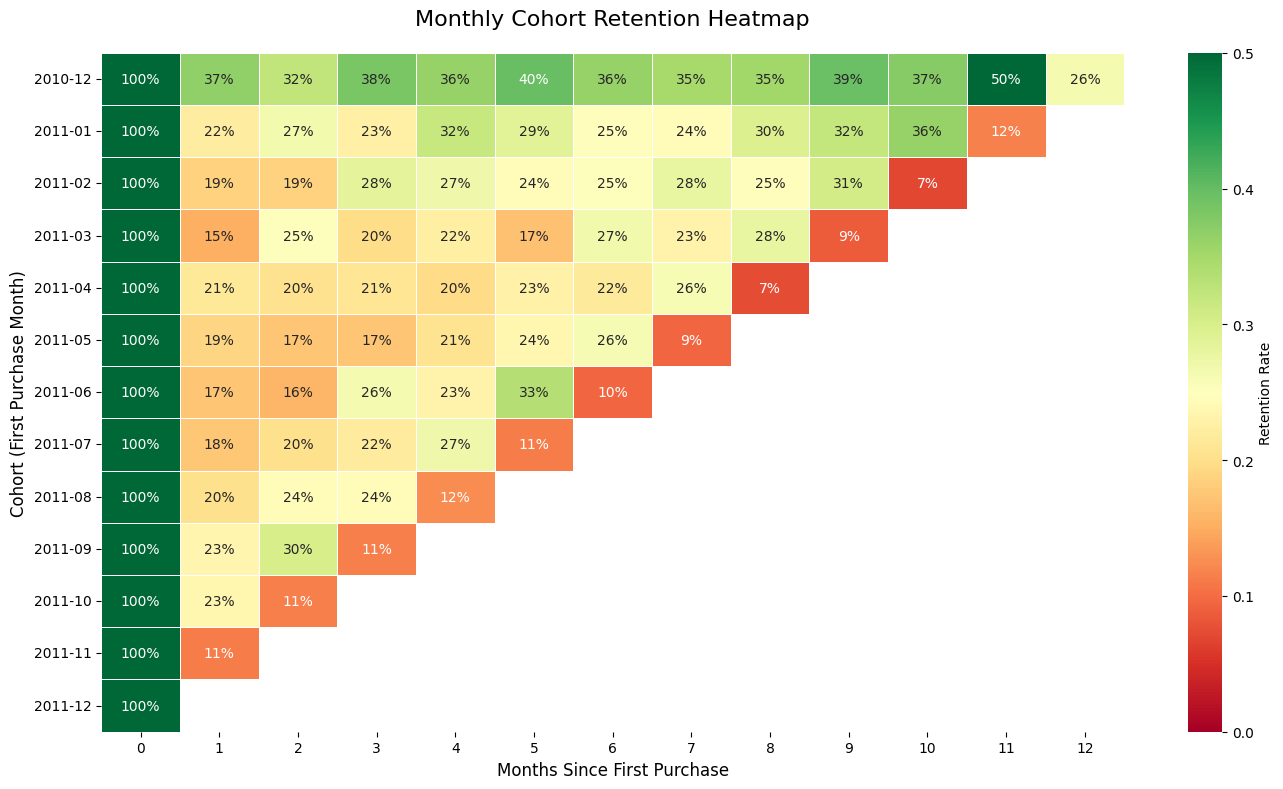

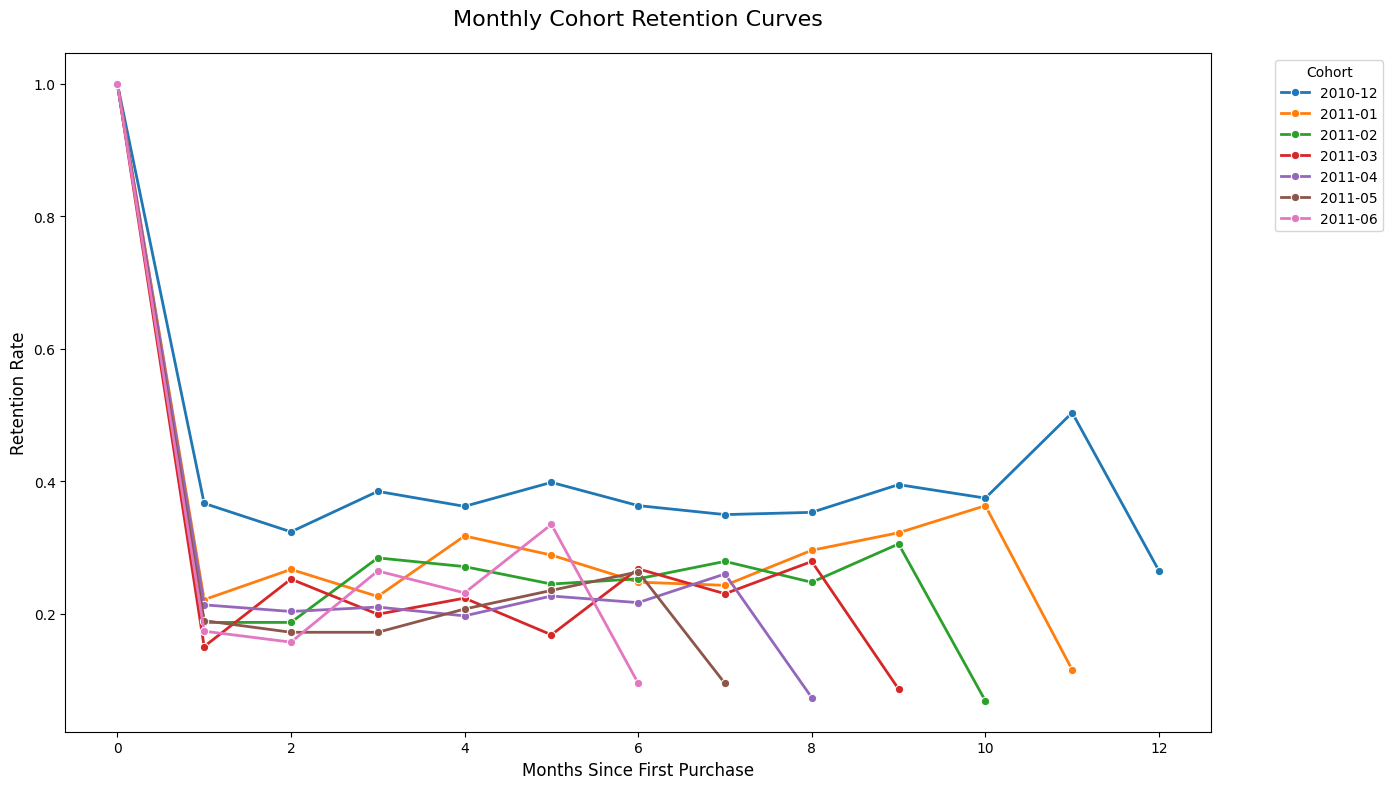

KEY METRICS (M1-M6 Analysis)

Dataset period: 2010-12-01 to 2011-12-09
Cohorts included (≥6 months data): ['2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06']
Number of cohorts: 7

=== Average Retention ===
M1:  21.4%
M3:  24.9%
M6:  24.4%

=== Churn Analysis ===
M0→M1 Churn:              78.6%  ← PRIMARY LEAK
M1→M3 Additional Churn:   -3.4%
M3→M6 Additional Churn:   0.5%

📊 RETENTION PATTERN:
   Re-engagement detected: M3 (24.9%) > M1 (21.4%)
   → Customers skip M1-M2, return in M3 (non-monthly purchase behavior)
   → Consider M3 reactivation campaigns for this cohort type

=== First Cohort vs Rest ===

M1 Retention:
  2010-12:      36.7%
  Rest (avg):   19.0%
  Difference:   +17.6% pp

M3 Retention:
  2010-12:      38.5%
  Rest (avg):   21.4%
  Difference:   +17.0% pp

M6 Retention:
  2010-12:      36.3%
  Rest (avg):   22.4%
  Difference:   +13.9% pp

✅ KEY FINDING:
   First cohort (2010-12) retains 18% better at M1
   This advantage persists: M3 (+17%), M6 

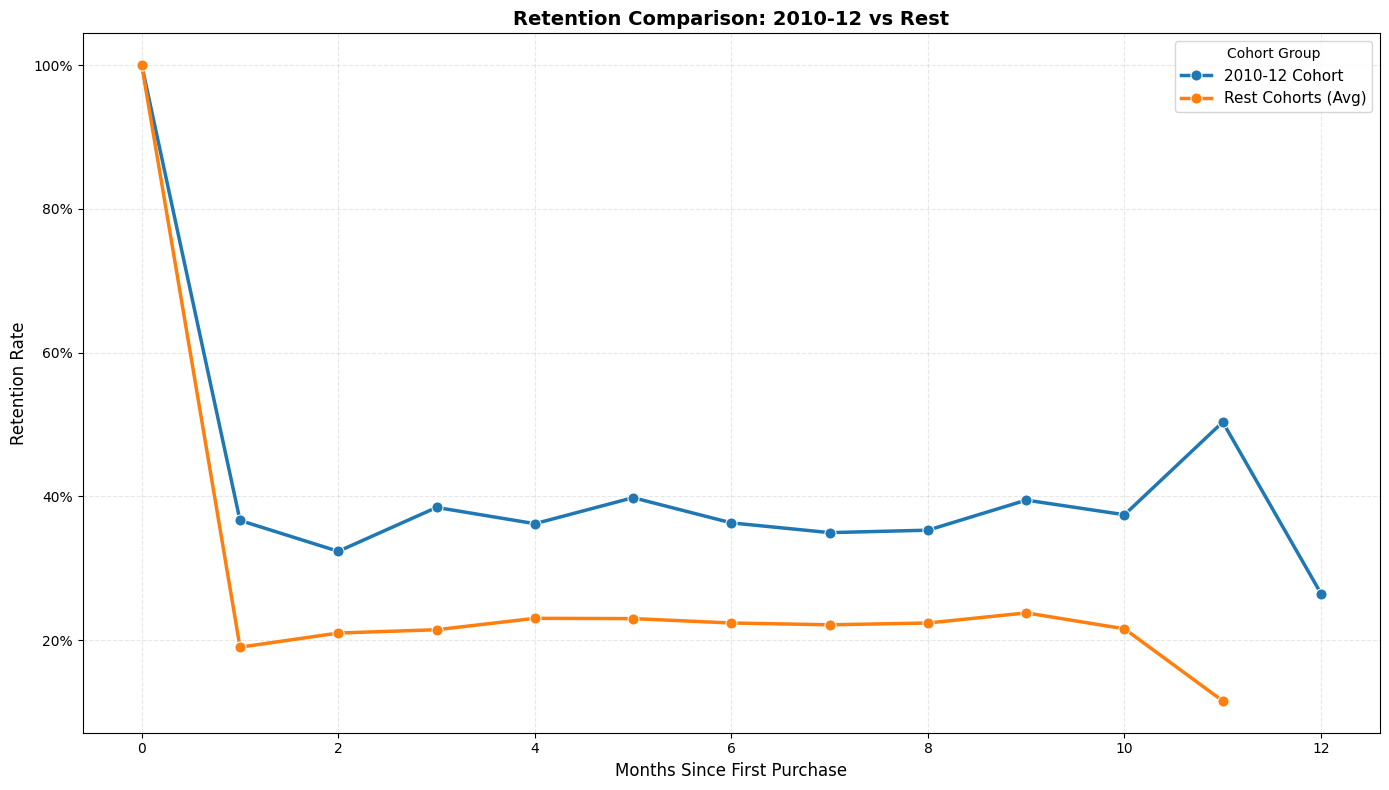


📊 COHORT RETENTION ANALYSIS - COMPLETED

KEY METRICS (based on 7 cohorts with 6+ months data):
• M1 Retention: 21.4%
• M3 Retention: 24.9% (M3 re-engagement pattern observed)
• M6 Retention: 24.4%

KEY FINDINGS:
1. M0→M1 churn cliff: 79% of customers don't purchase in M1
2. First cohort (2010-12) retains +18%pp better and shows re-engagement at M3
3. Non-monthly purchase behavior: customers may skip months and return later

IMPLICATIONS:
→ Priority #1: M1 nurture campaign (biggest opportunity)
→ Priority #2: Replicate 2010-12 acquisition profile
→ Priority #3: M3 reactivation campaigns for dormant customers
→ Consider non-linear purchase patterns in retention modeling

NEXT: RFM Segmentation (Notebook 02)
→ Identify which customer segments drive the retention patterns observed
→ Connect cohort behavior to customer value profiles




In [1]:
# ============================================================================
# 01. COHORT RETENTION ANALYSIS
# Business questions: What % of customers return in subsequent months?
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Format
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', '{:.2%}'.format)

# ============================================================================
## 1. DATA LOADING
# ============================================================================

retail_clean = pd.read_csv('online_retail_clean.csv', parse_dates=['InvoiceDate'])

print('='*70)
print('COHORT RETENTION ANALYSIS')
print('='*70)

print(f'\nDataset: {len(retail_clean):,} transactions')
print(f'Unique Customers: {retail_clean["CustomerID"].nunique():,}')
print(f'Unique Products: {retail_clean["StockCode"].nunique():,}')
print(f'Date range: {retail_clean["InvoiceDate"].min().date()} to {retail_clean["InvoiceDate"].max().date()}')

# ============================================================================
## 2. COHORT DEFINITION
# ============================================================================

# Identify first purchase by client
first_purchase = (
    retail_clean.groupby('CustomerID')['InvoiceDate']
    .min()
    .reset_index()
    .rename(columns={'InvoiceDate': 'first_purchase_date'})
)

# Crear columna de cohorte (YYYY-MM)
first_purchase['cohort'] = first_purchase['first_purchase_date'].dt.to_period('M').astype(str)

# Merge con datos originales
retail_cohort = retail_clean.merge(first_purchase, on='CustomerID', how='left')

# Calcular month_index (meses desde primera compra)
retail_cohort['purchase_month'] = retail_cohort['InvoiceDate'].dt.to_period('M')
retail_cohort['first_purchase'] = retail_cohort['first_purchase_date'].dt.to_period('M')
retail_cohort['month_index'] = (
    (retail_cohort['purchase_month'] - retail_cohort['first_purchase'])
    .apply(lambda x: x.n)
)

# ============================================================================
## 3. RETENTION CALCULATION
# ============================================================================

# Tamaño real de cada cohorte (TODOS los clientes, no solo los de M0)
cohort_sizes = (
    first_purchase
    .groupby('cohort')['CustomerID']
    .nunique()
    .reset_index()
    .rename(columns={'CustomerID': 'cohort_size'})
)

print("\n=== COHORT SIZES ===")
print(cohort_sizes.sort_values('cohort'))

# Clientes activos por cohorte y month_index
cohort_active = (
    retail_cohort.groupby(['cohort','month_index'])['CustomerID']
    .nunique()
    .reset_index(name='active_customers')
)

# Merge con cohort sizes
cohort_active = cohort_active.merge(cohort_sizes, on='cohort', how='left')
cohort_active['retention_rate'] = cohort_active['active_customers'] / cohort_active['cohort_size']

# Validación: M0 debe ser 100%
print("\n=== VALIDATION: M0 Retention Should Be 100% ===")
m0_check = cohort_active[cohort_active['month_index']==0][['cohort', 'retention_rate']].head()
print(m0_check)
if (cohort_active[cohort_active['month_index']==0]['retention_rate'] == 1.0).all():
    print(" M0 retention = 100% for all cohorts (correct)")
else:
    print(" WARNING: M0 retention ≠ 100% (check data)")

print("\n=== SAMPLE: Cohort 2010-12 Retention ===")
print(cohort_active[cohort_active['cohort'] == '2010-12'].head(10))

# ============================================================================
## 4. RETENTION HEATMAP
# ============================================================================

# Pivot para heatmap
heatmap_pivot = cohort_active.pivot_table(
    index='cohort',
    columns='month_index',
    values='retention_rate'
)

plt.figure(figsize=(14, 8))
sns.heatmap(
    data=heatmap_pivot,
    annot=True,
    cmap='RdYlGn',
    fmt='.0%',
    vmin=0,
    vmax=0.5,
    cbar_kws={'label': 'Retention Rate'},
    linewidths=0.5
)
plt.title('Monthly Cohort Retention Heatmap', fontsize=16, pad=20)
plt.ylabel('Cohort (First Purchase Month)', fontsize=12)
plt.xlabel('Months Since First Purchase', fontsize=12)
plt.tight_layout()
plt.show()

# ============================================================================
## 5. RETENTION CURVES
# ============================================================================

cohort_curves = cohort_active[cohort_active['cohort']<='2011-06']

plt.figure(figsize=(14, 8))
sns.lineplot(
    data=cohort_curves,
    x='month_index',
    y='retention_rate',
    hue='cohort',
    marker='o',
    linewidth=2
)
plt.title('Monthly Cohort Retention Curves', fontsize=16, pad=20)
plt.ylabel('Retention Rate', fontsize=12)
plt.xlabel('Months Since First Purchase', fontsize=12)
plt.legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ============================================================================
## 6. KEY METRICS
# ============================================================================

## 6A. OVERALL RETENTION METRICS (M1-M6 ANALYSIS)

print('='*70)
print('KEY METRICS (M1-M6 Analysis)')
print('='*70)

# Filtrar cohortes con al menos 6 meses de datos
max_date = retail_clean['InvoiceDate'].max()
cohort_cutoff_6m = (max_date - pd.DateOffset(months=6)).to_period('M').strftime('%Y-%m')

cohort_complete = cohort_active[cohort_active['cohort'] <= cohort_cutoff_6m]

print(f"\nDataset period: {retail_clean['InvoiceDate'].min().date()} to {max_date.date()}")
print(f"Cohorts included (≥6 months data): {sorted(cohort_complete['cohort'].unique())}")
print(f"Number of cohorts: {cohort_complete['cohort'].nunique()}")

# Average retention by month index
average_retention = (
    cohort_complete.groupby('month_index')['retention_rate']
    .mean()
    .reset_index()
)

# Retention by month index
M1_retention = average_retention[average_retention['month_index']==1]['retention_rate'].values[0]
M3_retention = average_retention[average_retention['month_index']==3]['retention_rate'].values[0]
M6_retention = average_retention[average_retention['month_index']==6]['retention_rate'].values[0]

print(f'\n=== Average Retention ===')
print(f'M1:  {M1_retention:.1%}')
print(f'M3:  {M3_retention:.1%}')
print(f'M6:  {M6_retention:.1%}')

# Churn
M0_M1_churn = 1 - M1_retention
M1_M3_churn = M1_retention - M3_retention
M3_M6_churn = M3_retention - M6_retention

print(f'\n=== Churn Analysis ===')
print(f'M0→M1 Churn:              {M0_M1_churn:.1%}  ← PRIMARY LEAK')
print(f'M1→M3 Additional Churn:   {M1_M3_churn:.1%}')
print(f'M3→M6 Additional Churn:   {M3_M6_churn:.1%}')

# Interpretación de patrón
print(f'\n📊 RETENTION PATTERN:')
if M3_retention > M1_retention:
    print(f'   Re-engagement detected: M3 ({M3_retention:.1%}) > M1 ({M1_retention:.1%})')
    print(f'   → Customers skip M1-M2, return in M3 (non-monthly purchase behavior)')
    print(f'   → Consider M3 reactivation campaigns for this cohort type')
elif abs(M1_M3_churn) < 0.03:
    print(f'   Retention stabilizes after M1 (M1→M3 change < 3pp)')
    print(f'   → Focus efforts on M1 nurture (biggest opportunity)')
elif M1_M3_churn < 0.10:
    print(f'   Moderate continued churn M1→M3 ({M1_M3_churn:.0%})')
    print(f'   → Consider M1 AND M3 interventions')
else:
    print(f'   Severe ongoing churn beyond M1 ({M1_M3_churn:.0%})')
    print(f'   → Multi-stage retention strategy needed')

print('='*70)

## 6B. FIRST COHORT ANOMALY ANALYSIS

# First cohort vs the rest
first_cohort = cohort_active[cohort_active['cohort']=='2010-12']
rest_cohort = cohort_active[cohort_active['cohort']>'2010-12']

# Average retention first cohort
avg_ret_first = (
    first_cohort.groupby('month_index')['retention_rate']
    .mean()
    .reset_index()
)
avg_ret_rest = (
    rest_cohort.groupby('month_index')['retention_rate']
    .mean()
    .reset_index()
)

# Retention by cohort & month index
# First cohort
M1_first_cohort = avg_ret_first[avg_ret_first['month_index']==1]['retention_rate'].values[0]
M3_first_cohort = avg_ret_first[avg_ret_first['month_index']==3]['retention_rate'].values[0]
M6_first_cohort = avg_ret_first[avg_ret_first['month_index']==6]['retention_rate'].values[0]

# Rest
M1_rest = avg_ret_rest[avg_ret_rest['month_index']==1]['retention_rate'].values[0]
M3_rest = avg_ret_rest[avg_ret_rest['month_index']==3]['retention_rate'].values[0]
M6_rest = avg_ret_rest[avg_ret_rest['month_index']==6]['retention_rate'].values[0]

# Diff
diff_m1 = M1_first_cohort - M1_rest
diff_m3 = M3_first_cohort - M3_rest
diff_m6 = M6_first_cohort - M6_rest

print(f'\n=== First Cohort vs Rest ===')

print(f'\nM1 Retention:')
print(f'  2010-12:      {M1_first_cohort:.1%}')
print(f'  Rest (avg):   {M1_rest:.1%}')
print(f'  Difference:   {diff_m1:+.1%} pp')

print(f'\nM3 Retention:')
print(f'  2010-12:      {M3_first_cohort:.1%}')
print(f'  Rest (avg):   {M3_rest:.1%}')
print(f'  Difference:   {diff_m3:+.1%} pp')

print(f'\nM6 Retention:')
print(f'  2010-12:      {M6_first_cohort:.1%}')
print(f'  Rest (avg):   {M6_rest:.1%}')
print(f'  Difference:   {diff_m6:+.1%} pp')

print(f"\n✅ KEY FINDING:")
if diff_m1 > 0.10:
    print(f"   First cohort (2010-12) retains {diff_m1:.0%} better at M1")
    print(f"   This advantage persists: M3 ({diff_m3:+.0%}), M6 ({diff_m6:+.0%})")
    print(f"\n   → HYPOTHESIS: Early adopters have superior retention profile")
    print(f"   → ACTION: Profile 2010-12 customers to replicate in acquisition")
elif diff_m1 < -0.05:
    print(f"   First cohort (2010-12) retains {diff_m1:.0%} WORSE at M1")
    print(f"   This suggests early product issues or data quality problems")
else:
    print(f"   First cohort performance is similar to rest (diff: {diff_m1:+.1%})")

print("="*70)

## 6C. VISUALIZATION: First Cohort vs Rest

# Prepare data for plotting
avg_ret_first['group'] = '2010-12 Cohort'
avg_ret_rest['group'] = 'Rest Cohorts (Avg)'
ret_comparison = pd.concat([avg_ret_first, avg_ret_rest], axis=0)
    
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=ret_comparison,
    x='month_index',
    y='retention_rate',
    hue='group',
    marker='o',
    linewidth=2.5,
    markersize=8
)
plt.title('Retention Comparison: 2010-12 vs Rest', fontsize=14, fontweight='bold')
plt.ylabel('Retention Rate', fontsize=12)
plt.xlabel('Months Since First Purchase', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.legend(title='Cohort Group', fontsize=11)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# ============================================================================
## 7. NOTEBOOK SUMMARY
# ============================================================================

print('\n' + '='*70)
print('📊 COHORT RETENTION ANALYSIS - COMPLETED')
print('='*70)

# Detectar si hay re-engagement
reengagement_note = ""
if M3_retention > M1_retention:
    reengagement_note = " (M3 re-engagement pattern observed)"

print(f"""
KEY METRICS (based on {cohort_complete['cohort'].nunique()} cohorts with 6+ months data):
• M1 Retention: {M1_retention:.1%}
• M3 Retention: {M3_retention:.1%}{reengagement_note}
• M6 Retention: {M6_retention:.1%}

KEY FINDINGS:
1. M0→M1 churn cliff: {M0_M1_churn:.0%} of customers don't purchase in M1
2. First cohort (2010-12) retains {diff_m1:+.0%}pp better and shows re-engagement at M3
3. Non-monthly purchase behavior: customers may skip months and return later

IMPLICATIONS:
→ Priority #1: M1 nurture campaign (biggest opportunity)
→ Priority #2: Replicate 2010-12 acquisition profile
→ Priority #3: M3 reactivation campaigns for dormant customers
→ Consider non-linear purchase patterns in retention modeling

NEXT: RFM Segmentation (Notebook 02)
→ Identify which customer segments drive the retention patterns observed
→ Connect cohort behavior to customer value profiles
""")

print('='*70 + '\n')
